# 5-5 损失函数loss
一般来说, 监督学习的目标函数由损失函数和正则化项组成。(Objective = Loss + Regularization)

Pytorch中的损失函数一般在训练模型时候指定。

注意Pytorch中内置的损失函数的参数和TensorFlow不同, 是y_pred在前, y_true在后, 而tf则相反。

对于回归模型, 通常使用的内置损失函数一般是nn.MSELoss。

对于二分类模型一般用nn.BCELoss(输入已经是sigmoid之后的结果)或者nn.BCEWithLogitsLoss(输入尚未经过sigmoid)

对于多分类则推荐用nn.CrossEntropyLoss。(y_pred未经过nn.Softmax)。如果经过了softmax则可以用NNLLLoss。

Pytorch中的正则化项一般通过自定义的方式和损失函数一起添加作为目标函数。

如果仅仅使用L2正则化, 也可以用优化器的weight_decay参数来实现相同的效果。

## 一、内置损失函数

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
y_pred = torch.tensor([[10.0, 0, -10], [8, 8, 8]])
y_true = torch.tensor([0, 2])

In [3]:
# 直接调用交叉熵损失
ce = nn.CrossEntropyLoss()(y_pred, y_true)
print(ce)

tensor(0.5493)


In [4]:
# 等价于先计算LogSoftmax再用NLLoss
y_pred_logsoftmax = nn.LogSoftmax(dim = 1)(y_pred)
nll = nn.NLLLoss()(y_pred_logsoftmax, y_true)
print(nll)

tensor(0.5493)


内置函数一般都有类和函数两种实现形式

## 二、自定义损失函数
自定义损失函数可以接受两个张量y_pred, y_true

也可以对nn.Module进行子类化, 重写forward方法实现计算逻辑。

下面是一个Focal Loss的自定义实现示范。Focal Loss是一种对binary_crossentropy的改进损失函数的一种形式。

它在样本不均衡和存在较多易分类的样本相比binary_crossentropy更有优势。

它有两个可调节参数, alpha和gamma。其中alpha主要用于衰减负样本的权重, gamma主要用于衰减容易训练样本的权重。从而让模型更加聚焦在正样本和困难样本上, 这就是为什么这个损失函数叫Focal loss

$$focal\_loss(y,p) = 
\begin{cases} -\alpha (1-p)^{\gamma}\log(p) & \text{if y = 1}\\
-(1-\alpha) p^{\gamma}\log(1-p) & \text{if y = 0} 
\end{cases} $$


In [8]:
class FocalLoss(nn.Module):
    
    def __init__(self, gamma=2.0, alpha=0.75):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        
    def forward(self, y_pred, y_true):
        """这么写充分利用了向量运算的特性, 不用在if else什么的
        """
        bce = torch.nn.BCELoss(reduction="none")(y_pred, y_true)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = torch.pow(1.0 - p_t, self.gamma)
        loss = torch.mean(alpha_factor * modulating_factor * bce)
        return loss

In [10]:
# 困难样本
y_pred_hard = torch.tensor([[0.5], [0.5]])
y_true_hard = torch.tensor([[1.], [0.0]])

# 容易样本
y_pred_easy = torch.tensor([[0.9], [0.1]])
y_true_easy = torch.tensor([[1.], [0]])

focal_loss = FocalLoss()
bce_loss = nn.BCELoss()

print("focal_loss(hard samples):", focal_loss(y_pred_hard, y_true_hard))
print("bce_loss(hard samples):", bce_loss(y_pred_hard, y_true_hard))
print("focal_loss(easy samples):", focal_loss(y_pred_easy, y_true_easy))
print("bce_loss(easy samples):", focal_loss(y_pred_easy, y_true_easy))

focal_loss(hard samples): tensor(0.0866)
bce_loss(hard samples): tensor(0.6931)
focal_loss(easy samples): tensor(0.0005)
bce_loss(easy samples): tensor(0.0005)


可见 focal_loss让容易样本的权重衰减到原来的 0.0005/0.1054 = 0.00474
而让困难样本的权重只衰减到原来的 0.0866/0.6931=0.12496

 因此相对而言，focal_loss可以衰减容易样本的权重

## 三、自定义L1和L2正则化项
通常认为L1正则化可以产生稀疏权重矩阵, 可以用于特征选择。

而L2正则化可以防止过拟合。一定程度上, L1也可以防止过拟合。

下面以一个二分类问题为例子, 演示给模型的目标函数添加自定义L1和L2正则化的方法。

### 1.准备数据

In [11]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchkeras 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 200,6000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)

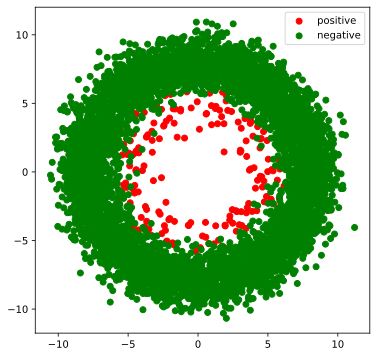

In [12]:
#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"])

In [14]:
ds = TensorDataset(X,Y)

ds_train,ds_valid = torch.utils.data.random_split(ds,[int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 8,shuffle=True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 8,num_workers=2)

### 2.定义模型

In [15]:
class DNNModel(torchkeras.Model):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8) 
        self.fc3 = nn.Linear(8,1)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y

model = DNNModel()

model.summary(input_shape =(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              12
            Linear-2                    [-1, 8]              40
            Linear-3                    [-1, 1]               9
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000340
----------------------------------------------------------------


### 3.训练模型

In [25]:
# 准确率
def accuracy(y_pred,y_true):
    y_pred = torch.where(y_pred>0.5,torch.tensor(1.0),
                      torch.tensor(0.0))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc

# L2正则化
def L2Loss(model, alpha):
    l2_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if "bias" not in name:  # 一般不对偏置项使用正则
            l2_loss = l2_loss + (0.5 * alpha * torch.sum(torch.pow(param, 2)))
        return l2_loss

# L1正则化
def L1Loss(model, beta):
    l1_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if "bias" not in name:
            l1_loss = l1_loss + beta * torch.sum(torch.abs(param))
        return l1_loss
    
# 将L2, L1和FocalLoss一起作为损失
def focal_loss_with_regularization(y_pred, y_true):
    focal = FocalLoss()(y_pred, y_true)
    l2_loss = L2Loss(model, 0.001)
    l1_loss = L1Loss(model, 0.001)
    return focal + l1_loss + l2_loss

In [26]:
model.compile(loss_func=focal_loss_with_regularization,
              optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
             metrics_dict={"accuracy": accuracy})

In [27]:
dfhistory = model.fit(10, dl_train=dl_train, dl_val=dl_valid, log_step_freq=30)

Start Training ...

================================================================================2020-09-26 23:12:31
{'step': 30, 'loss': 0.044, 'accuracy': 0.646}
{'step': 60, 'loss': 0.035, 'accuracy': 0.802}
{'step': 90, 'loss': 0.032, 'accuracy': 0.854}
{'step': 120, 'loss': 0.029, 'accuracy': 0.883}
{'step': 150, 'loss': 0.026, 'accuracy': 0.903}
{'step': 180, 'loss': 0.025, 'accuracy': 0.913}
{'step': 210, 'loss': 0.024, 'accuracy': 0.922}
{'step': 240, 'loss': 0.024, 'accuracy': 0.928}
{'step': 270, 'loss': 0.023, 'accuracy': 0.933}
{'step': 300, 'loss': 0.023, 'accuracy': 0.936}
{'step': 330, 'loss': 0.022, 'accuracy': 0.939}
{'step': 360, 'loss': 0.022, 'accuracy': 0.941}
{'step': 390, 'loss': 0.022, 'accuracy': 0.942}
{'step': 420, 'loss': 0.022, 'accuracy': 0.944}
{'step': 450, 'loss': 0.022, 'accuracy': 0.945}
{'step': 480, 'loss': 0.022, 'accuracy': 0.947}
{'step': 510, 'loss': 0.021, 'accuracy': 0.947}
{'step': 540, 'loss': 0.021, 'accuracy': 0.949}

 +-------+-------+

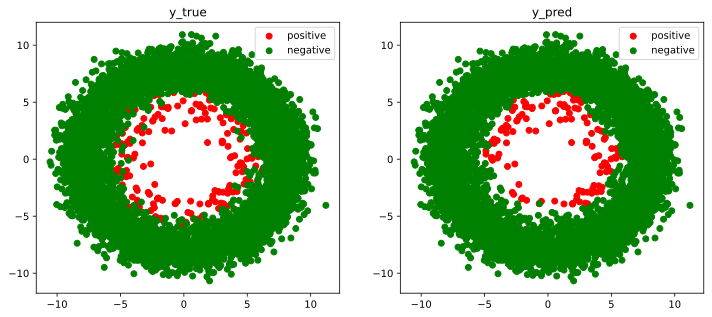

In [28]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

## 四、通过优化器实现L2正则化
如果仅仅需要使用L2正则化，那么也可以利用优化器的weight_decay参数来实现。

weight_decay参数可以设置参数在训练过程中的衰减，这和L2正则化的作用效果等价

```
before L2 regularization:

gradient descent: w = w - lr * dloss_dw 

after L2 regularization:

gradient descent: w = w - lr * (dloss_dw+beta*w) = (1-lr*beta)*w - lr*dloss_dw

so （1-lr*beta）is the weight decay ratio
```

Pytorch的优化器支持一种称之为Per-parameter options的操作，就是对每一个参数进行特定的学习率，权重衰减率指定，以满足更为细致的要求。

```python
weight_params = [param for name, param in model.named_parameters() if "bias" not in name]
bias_params = [param for name, param in model.named_parameters() if "bias" in name]

optimizer = torch.optim.SGD([{'params': weight_params, 'weight_decay':1e-5},
                             {'params': bias_params, 'weight_decay':0}],
                            lr=1e-2, momentum=0.9)

```

In [33]:
"bias" in "sss_bias_sss"  # 子串匹配

True